In [32]:
import os
from pathlib import Path
import imageio, numpy
from PIL import Image, ImageDraw, ImageFont

def search_files(directory):
    mp4Path = []
    dataPath = {}
    path = Path(directory)
    for file in path.rglob("*"):  # 递归搜索所有文件
        if file.is_file():  # 确保是文件
            tmp = file.name[0:-4]
            extension = file.name[-3:]
            if extension == "mp4": 
                mp4Path.append(str(file))
            elif extension == "txt": 
                tmp2 = str(tmp).split("+")
                scene_name = tmp2[0]
                id = tmp2[1]
                scene_id = scene_name + ".mp4"
                if scene_id not in dataPath:
                    dataPath[scene_id] = {}
                dataPath[scene_id][id] = str(file)
            
            
            
    return mp4Path, dataPath

# 示例：搜索当前文件夹下的所有文件
mp4Path, dataPath = search_files("/home/jjlin/pluto/result")

mp4Path
dataPath




{'2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68.mp4': {'epoch=14-val_minFDE=0.000.ckpt': '/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68+epoch=14-val_minFDE=0.000.ckpt.txt',
  'epoch=13-val_minFDE=0.000.ckpt': '/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68+epoch=13-val_minFDE=0.000.ckpt.txt',
  'epoch=14-val_minFDE=0.000-v1.ckpt': '/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68+epoch=14-val_minFDE=0.000-v1.ckpt.txt',
  'epoch=11-val_minFDE=0.000.ckpt': '/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68+epoch=11-val_minFDE=0.000.ckpt.txt',
  'epoch=12-val_minFDE=0.000.ckpt': '/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68+epoch=12-val_minFDE=0.000.ckpt.txt'},
 '2021.06.03.12.02.06_veh-35_00233_00609_310cdc079b215731.mp4': {'epoch=14-val_minFDE=0.000-v1.ckpt': '/home/jjlin/pluto/result/2021.06.03.12.02.06_veh-35_

In [23]:
import numpy as np
from scipy.signal import lfilter
 
def low_pass_filter(data, cutoff):
    b = [0.25, 0.5, 0.25]  # 简单的低通滤波器系数，例如三角窗滤波器
    a = [1.0]  # 分母系数为1，表示无延迟滤波器
    filtered_data = lfilter(b, a, data)
    return filtered_data
 
cutoff = 0.5  # 这里cutoff参数通常用于设计滤波器，具体值根据需要而定


In [33]:
for path in mp4Path:
    # 输入视频路径
    input_video_path = path
    # 输出视频路径
    output_video_path = path[0:-4] + ".new.mp4"

    # 加载视频
    reader = imageio.get_reader(input_video_path)
    fps = reader.get_meta_data()['fps']  # 获取帧率

    # 创建视频写入器
    writer = imageio.get_writer(output_video_path, fps=fps)

    font_path = "/usr/share/fonts/truetype/freefont/FreeSans.ttf"  # 字体文件路径（确保系统中存在该字体）
    font_size = 30
    font = ImageFont.truetype(font_path, font_size)

    risk = []
    flag = 0
    
    files = [open(value, 'r') for value in dataPath[path.split("/")[-1]].values()]
    while flag < len(files):
        data = []
        for i in range(len(files)):
            data.append([])
        i = -1
        for file in files:
            line = file.readline()
            if not line:
                flag += 1
                continue
            i += 1
            states = line.split('*')
            
            for state in states[0:-1]:
                data[i].append([float(n) for n in state.split(",")])
        mean = [0, 0, 0]
        for j in range(len(data[0])):
            for k in range(3):
                result = []
                for i in range(len(data)):
                        try:
                            result.append(data[i][j][k])
                        except:
                            continue
                mean[k] += numpy.var(result)
        risk.append(sum(mean))
    for file in files:
        file.close()
    smoothed_risk = risk #low_pass_filter(risk, cutoff)
    time = 0
    # 遍历每一帧
    for frame in reader:
        # 将帧转换为 PIL 图像
        pil_image = Image.fromarray(frame)

        # 创建绘图对象
        draw = ImageDraw.Draw(pil_image)

        # 设置文字位置（左上角）
        text_position = (10, 10)

        text_color = (255, 0, 0)
        
        if time < len(smoothed_risk):
            text = str(smoothed_risk[time])
        else:
            text = "Simulation stop"
            #if smoothed_risk[time] == 0:
            #    text = "Emergency brake"
        # 在图像上绘制文字
        draw.text(text_position, text,fill=text_color, font=font)

        # 将 PIL 图像转换回 numpy 数组
        frame_with_text = numpy.array(pil_image)

        # 将帧写入输出视频
        writer.append_data(frame_with_text)
        time += 1

    # 关闭读取器和写入器
    reader.close()
    writer.close()

    print(f"视频已处理并保存到：{output_video_path}")


视频已处理并保存到：/home/jjlin/pluto/result/2021.06.14.19.22.11_veh-38_01480_01860_f12256faa4f55140.new.mp4
视频已处理并保存到：/home/jjlin/pluto/result/2021.10.06.17.43.07_veh-28_00508_00877_07340f5416b95c68.new.mp4
视频已处理并保存到：/home/jjlin/pluto/result/2021.09.16.15.12.03_veh-42_01037_01434_f818163ed0f95461.new.mp4
视频已处理并保存到：/home/jjlin/pluto/result/2021.06.03.12.02.06_veh-35_00233_00609_310cdc079b215731.new.mp4


In [42]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# 加载 .mat 文件
mat_data = scipy.io.loadmat('/home/jjlin/pluto_dev/result/log/2021.08.17.16.57.11_veh-08_01200_01636_9e30155b8bb55fd9_exp.ckpt.mat')

# 显示 .mat 文件中的键（变量名）
#print("Keys in the .mat file:", mat_data.keys())

# print("Keys in the .mat file:", mat_data["data_3"].dtype.names)

i = 1
emergency = []
traj_var = []
prob_var = []
traj_chosed = []
final_score = []
pred_var = []
e_traj_var = []
is_e_traj = False
if mat_data["1"]["e_traj_var"]:
    is_e_traj = True

while str(i) in mat_data.keys():
    #print(mat_data[str(i)].dtype.names)
    emergency.append(mat_data[str(i)]["emergency"][0, 0][0, 0])
    traj_var.append(mat_data[str(i)]["traj_var"][0, 0][0, 0])
    prob_var.append(mat_data[str(i)]["prob_var"][0, 0][0, 0])
    final_score.append(mat_data[str(i)]["final_score"][0, 0][0, 0])
    pred_var.append(mat_data[str(i)]["pred_var"][0, 0][0])
    e_traj_var.append(mat_data[str(i)]["e_traj_var"][0, 0][0, 0] if is_e_traj else 0)
    i += 1
time = range(1, i)
#pred_var
# emergency

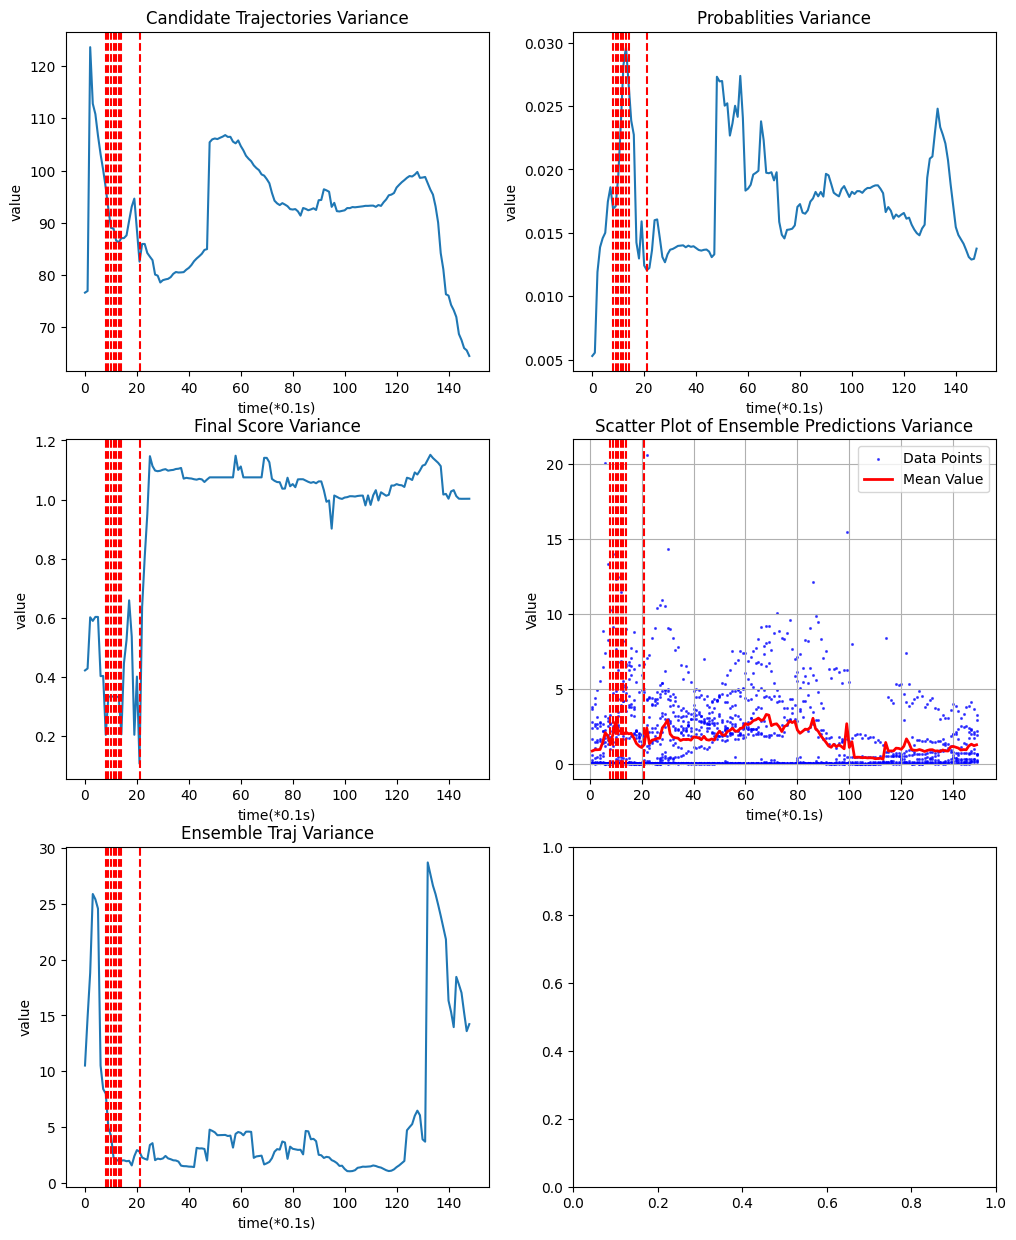

In [44]:
fig, ax = plt.subplots(3,2,figsize=(12,15))

ax[0,0].plot(traj_var,  label='traj var')
ax[0,0].set_title("Candidate Trajectories Variance")
ax[0,0].set_xlabel("time(*0.1s)")
ax[0,0].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[0,0].axvline(x=i, color='r',linestyle='--', linewidth=1.5)

ax[0,1].plot(prob_var,  label='prob var')
ax[0,1].set_title("Probablities Variance")
ax[0,1].set_xlabel("time(*0.1s)")
ax[0,1].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[0,1].axvline(x=i, color='r',linestyle='--', linewidth=1.5)

ax[1,0].plot(final_score,  label='final score')
ax[1,0].set_title("Final Score Variance")
ax[1,0].set_xlabel("time(*0.1s)")
ax[1,0].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[1,0].axvline(x=i, color='r',linestyle='--', linewidth=1.5)

# 绘制散点图
for t, arr in zip(time, pred_var):
    ax[1,1].scatter([t] * arr.shape[0], arr,s=1.5, color='blue', alpha=0.6, label='Data Points' if t == time[0] else "")

# 计算每个时间点的平均值
means = [np.mean(arr) for arr in pred_var]

# 绘制平均值折线图
ax[1,1].plot(time, means, color='red',linestyle='-', linewidth=2, label='Mean Value')

# 添加标签和标题
ax[1,1].set_xlabel("time(*0.1s)")
ax[1,1].set_ylabel("Value")
ax[1,1].set_title('Scatter Plot of Ensemble Predictions Variance')
ax[1,1].legend()
ax[1,1].grid(True)
for i, e in enumerate(emergency):
    if e:
        ax[1,1].axvline(x=i, color='r',linestyle='--', linewidth=1.5)
#ax[1,1].plot([100 if e else 0 for e in emergency],  label='final score')

ax[2,0].plot(e_traj_var,  label='e traj var')
ax[2,0].set_title("Ensemble Traj Variance")
ax[2,0].set_xlabel("time(*0.1s)")
ax[2,0].set_ylabel("value")
for i, e in enumerate(emergency):
    if e:
        ax[2,0].axvline(x=i, color='r',linestyle='--', linewidth=1.5)

plt.show()